In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import fnmatch
from os.path import basename

## read-in and pre-process data. All files with .dat extension in the current directory are processed

Text(0,0.5,'Work (kT)')

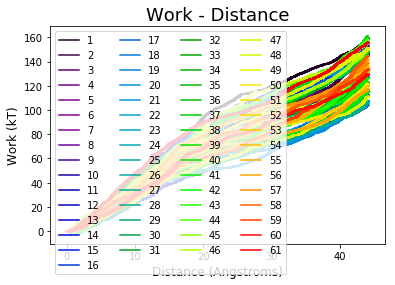

In [2]:
# create color map for plots
cm = plt.get_cmap('nipy_spectral')
colors = [cm(1.*i/71) for i in range(71)]

# output in SMD is reported as time step (unitless), force (pN)

v = 0.005 #the velocity unit is A/ps --> Angstrom/timestep = 0.00001/2fs = 0.005 A/ps = 5 A/ns
TS = 0.024 #smd output saving frequency is 12 timestep which is 2 fs * 12 = 24 fs = 0.024 ps
temperature = 310 # temperature of the simulations
kB = 1.987e-3 # Boltzmann constant in kcal/mol/K
kBT = kB * temperature #temperature * Boltzmann's constant --> 310 * kB = 0.6186 kcal/mol
conv_factor = 0.0144 #NAMD reports forces in pN; u converts the outputs of W = v*TS*f to kcal/mol
count = 0
N_max = 122900 # no. of data points to read from the files; this should be the shorter than the shortest no of data points amongst all uploaded files.

jW_data = []
jWx_data = []
W_data = []
Wsq_data = []
t_data = []

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*.dat'):
        prefix_name = file
        data = np.genfromtxt(prefix_name)
        timestep = data[:N_max,0]    # read the position of SMD atom projected on the pulling direction  
        t = timestep - timestep[0]   # rxn coordinate starts from 0 at init. position and is along the pulling dir.
        force = data[:N_max,1]
        f = np.cumsum(force, axis=0)
        W = v*TS*f*conv_factor / kBT # work values in units of kT
        Wsq = np.square(W)
        count += 1 

#   use the following to find out the data set labels diverging from intended path after 
#   inspecting the individual Work curves at the end of this block
#   once satisfied with them, remove those files from the current directory and rerun the block
#
#        if any(W > 130):
#            print('final energy diverged for',prefix_name)
#   
        
    #plotting each Work curve
        plt.plot(t,W,color=colors[count],label=count)
        jW = np.exp(-W)
        W_max = np.max(-W)  # maximum argument for Work values; to be used in std error of exponential averaging
        jWx = np.exp(-W-W_max)
        
    #appending all data necessary 
        jW_data.append(jW)
        jWx_data.append(jWx)
        W_data.append(W)
        Wsq_data.append(Wsq)
        t_data.append(t)
        
        
plt.legend(loc='upper left')
plt.xlabel('Time (ns)')
plt.ylabel('Work (kT)')

plt.legend(loc='upper left', ncol=4)

plt.title("Work - Distance", fontsize=18)
plt.xlabel('Distance (Angstroms)', fontsize=12)
plt.ylabel('Work (kT)', fontsize=12)


In [3]:
jWmean = np.mean(jW_data, axis = 0) # exponential averages
jWxmean = np.mean(jWx_data, axis = 0) # averages of the deviations from the distribution
jWxsterr = np.std(jWx_data, axis=0)/ np.sqrt(count) / jWxmean #standard error on exponential averaging
jWfinal = -np.log(jWmean)

Wmean = np.mean(W_data, axis = 0) #average work
Wsterr = np.std(W_data, axis=0) / np.sqrt(count)  #standard error
Wsq_mean = np.mean(Wsq_data, axis = 0) #calculates average of work^2 for each time point
Wmean_sq = np.square(Wmean) # takes square of average work
diff = Wmean - (Wsq_mean - Wmean_sq)*count/(count-1)/2 # second cumulant result


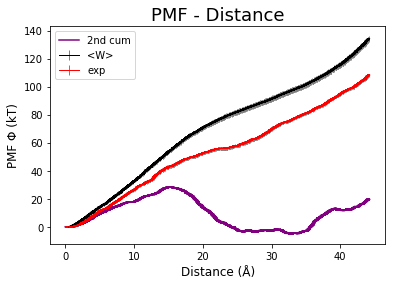

In [4]:
# Plot all of the results
plt.errorbar(t,Wmean, yerr = Wsterr,fmt='-',ecolor = 'gray',color='black',errorevery = 100, linewidth=1,label='<W>')
plt.errorbar(t,jWfinal, yerr = jWxsterr,fmt='-',ecolor = 'gray',color='red',errorevery = 100, linewidth=1,label='exp')
plt.plot(t,diff,color='purple',label='2nd cum')

plt.legend()
plt.title("PMF - Distance", fontsize=18)
plt.xlabel('Distance (\u212B)', fontsize=12)
plt.ylabel('PMF \u03A6 (kT)', fontsize=12)

plt.savefig('Wmean_expavg_2ndcum.png', dpi=300, bbox_inches='tight')


### Now the same calculations with binning

In [5]:
#=============================================================================================
# PARAMETERS
#=============================================================================================
K = count # number of samples
nbins = 100 # number of bins for 1D PMF
total_rxncoord = 40 # total rxn coordinate to be plotted

#=============================================================================================
# Allocate storage for simulation data
#=============================================================================================
N_k = np.zeros([K], dtype = int) # N_k[k] is the number of snapshots from simulation k


In [6]:
### Function for block averaging the data; taken from github: shane5ul/blockAverage.py

def blockAverage(datastream, isplot=True, maxBlockSize=0):
    
# This program computes the block average of a potentially correlated timeseries "x", and 
# provides error bounds for the estimated mean <x>. 
# As input provide a vector or timeseries "x", and the largest block size.
#
# Check out writeup in the following blog posts for more:
# http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty_14.html
# http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty.html
#
 
    Nobs         = len(datastream)           # total number of observations in datastream
    minBlockSize = 1;                        # min: 1 observation/block
 
    if maxBlockSize == 0:
        maxBlockSize = int(Nobs/4);        # max: 4 blocs (otherwise can't calc variance)
  
    NumBlocks = maxBlockSize - minBlockSize   # total number of block sizes

    blockMean = np.zeros(NumBlocks)               # mean (expect to be "nearly" constant)
    blockVar  = np.zeros(NumBlocks)               # variance associated with each blockSize
    blockCtr  = 0

#
#  blockSize is # observations/block
#  run them through all the possibilities
#
 
    for blockSize in range(minBlockSize, maxBlockSize):

        Nblock    = int(Nobs/blockSize)               # total number of such blocks in datastream
        obsProp   = np.zeros(Nblock)                  # container for parcelling block 

# Loop to chop datastream into blocks
# and take average
        for i in range(1,Nblock+1):

            ibeg = (i-1) * blockSize
            iend =  ibeg + blockSize
            obsProp[i-1] = np.mean(datastream[ibeg:iend])

        blockMean[blockCtr] = np.mean(obsProp)
        blockVar[blockCtr]  = np.var(obsProp)/(Nblock - 1)
        blockCtr += 1
 
    v = np.arange(minBlockSize,maxBlockSize)
#    print("<x> = {0:f} +/- {1:f}".format(blockMean[-1], np.sqrt(blockVar[-1])))

 
    if isplot:

        plt.subplot(2,1,1)
        plt.plot(v, np.sqrt(blockVar),'ro-',lw=2)
        plt.xlabel('block size')
        plt.ylabel('std')

        plt.subplot(2,1,2)
        plt.errorbar(v, blockMean, np.sqrt(blockVar))
        plt.ylabel('<x>')
        plt.xlabel('block size')

        plt.tight_layout()
        plt.show()
    
    return v, blockVar, blockMean

In [7]:
# Construct bins on rxn coordinate

for k in range(K):
    N_k[k] = N_max

print("Binning data...")
delta = total_rxncoord / float(nbins) 
print(delta)

# compute bin centers
bin_center_i = np.zeros([nbins], np.float64)
for i in range(nbins):
    bin_center_i[i] = delta/2 + delta * i
print(bin_center_i)    
# Bin data
bin_kn = np.zeros([K,N_max], np.int32)
for k in range(K):
    for n in range(N_k[k]):
        # Compute bin assignment for 2D array
        bin_kn[k,n] = int(t_data[k][n] / delta)
        
bin_n = np.zeros([N_max], np.int32)
for n in range(N_k[k]):
    # Compute bin assignment
    bin_n[n] = int(t[n] / delta)


Binning data...
0.4
[ 0.2  0.6  1.   1.4  1.8  2.2  2.6  3.   3.4  3.8  4.2  4.6  5.   5.4
  5.8  6.2  6.6  7.   7.4  7.8  8.2  8.6  9.   9.4  9.8 10.2 10.6 11.
 11.4 11.8 12.2 12.6 13.  13.4 13.8 14.2 14.6 15.  15.4 15.8 16.2 16.6
 17.  17.4 17.8 18.2 18.6 19.  19.4 19.8 20.2 20.6 21.  21.4 21.8 22.2
 22.6 23.  23.4 23.8 24.2 24.6 25.  25.4 25.8 26.2 26.6 27.  27.4 27.8
 28.2 28.6 29.  29.4 29.8 30.2 30.6 31.  31.4 31.8 32.2 32.6 33.  33.4
 33.8 34.2 34.6 35.  35.4 35.8 36.2 36.6 37.  37.4 37.8 38.2 38.6 39.
 39.4 39.8]


In [8]:
# Compute the free energies for these states
Wmean_i = np.zeros([nbins], np.float64)
Wsterr_i = np.zeros([nbins], np.float64)
Wsq_mean_i = np.zeros([nbins], np.float64)
Wmean_sq_i = np.zeros([nbins], np.float64)
jWmean_i = np.zeros([nbins], np.float64)
jWxmean_i = np.zeros([nbins], np.float64)
jWxsterr_i = np.zeros([nbins], np.float64)
diff_i = np.zeros([nbins], np.float64)
diffsterr_i = np.zeros([nbins], np.float64)

for i in range(nbins):
    # Get linear n-indices of samples that fall in this bin.
    indices = np.where(bin_kn == i)    
    # Compute dimensionless free energy of occupying state i.
    Wmean_i[i] = np.mean(np.array(W_data)[indices])  ### from mean of work
    Wsterr_i[i] = np.std(np.array(W_data)[indices]) / np.sqrt(count)    
    Wsq_mean_i[i] = np.mean(np.array(Wsq_data)[indices]) #calculates average of work^2 for each bin
    jWmean_i[i] = np.mean(np.array(jW_data)[indices])  ### exponential averages
    jWxmean_i[i] = np.mean(np.array(jWx_data)[indices])  ### averages of the deviations from the distribution
    jWxsterr_i[i] = np.std(np.array(jWx_data)[indices]) / np.sqrt(count) / jWxmean_i[i]  ### standard error for exponential averaging
    
    indice = np.where(bin_n == i)
    datastream = np.array(diff)[indice]
    v, blockVar, blockMean = blockAverage(datastream, isplot=False, maxBlockSize=0)
    diffsterr_i[i] = np.sqrt(blockVar[-1])
    diff_i[i] = blockMean[-1]

jWfinal_i = -np.log(jWmean_i)


In [9]:
print('averages are for', K, 'sets of data')

averages are for 61 sets of data


In [10]:
# Save data into files

f = open('Energies_kT.txt', 'w')
f.write('energies in units of kT \n')
f.write('Rxn. coord (\u212B), <W>, d<W>, exp avg., d(exp avg.),2.cum, d(2.cum) \n')
data = np.column_stack((bin_center_i,Wmean_i,Wsterr_i, jWfinal_i, jWxsterr_i, diff_i, diffsterr_i))
np.savetxt(f, data,fmt='%7.2f')
f.close()

f = open('Energies_kcal_per_mol.txt', 'w')
f.write('energies in kcal/mol \n')
f.write('Rxn. coord (\u212B), <W>, d<W>, exp avg., d(exp avg.),2.cum, d(2.cum) \n')
data = np.column_stack((bin_center_i,Wmean_i*kBT,Wsterr_i*kBT, jWfinal_i*kBT, jWxsterr_i*kBT, diff_i*kBT, diffsterr_i*kBT))
np.savetxt(f, data,fmt='%7.2f')
f.close()

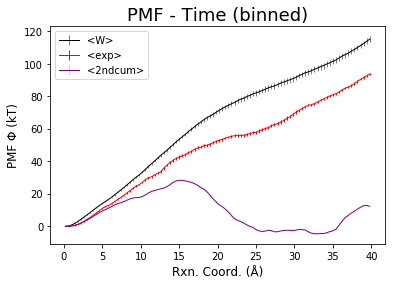

In [11]:
plt.title("PMF - Time (binned)", fontsize=18)
plt.xlabel('Rxn. Coord. (\u212B)', fontsize=12)
plt.ylabel('PMF \u03A6 (kT)', fontsize=12)

plt.errorbar(bin_center_i,Wmean_i, yerr = Wsterr_i,fmt='-',ecolor = 'gray',color='black',errorevery = 1, linewidth=1,label='<W>')
plt.errorbar(bin_center_i,jWfinal_i, yerr = jWxsterr_i,fmt='-',ecolor = 'red',color='red',errorevery = 1, linewidth=1,label='<exp>')
plt.errorbar(bin_center_i,diff_i, yerr = diffsterr_i,fmt='-',ecolor = 'pink',color='purple',errorevery = 1, linewidth=1,label='<2ndcum>')
plt.legend()

plt.savefig('Wmean_expavg_2ndcum_binned.png', dpi=300, bbox_inches='tight')


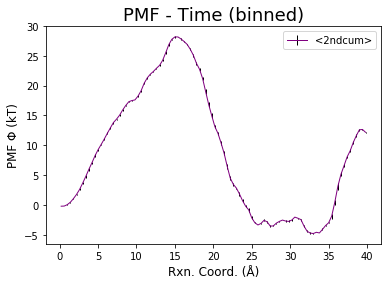

In [12]:
### plot only the PMF from second cumulant 

plt.title("PMF - Time (binned)", fontsize=18)
plt.xlabel('Rxn. Coord. (\u212B)', fontsize=12)
plt.ylabel('PMF \u03A6 (kT)', fontsize=12)

plt.errorbar(bin_center_i,diff_i, yerr = diffsterr_i,fmt='-',ecolor = 'black',color='purple',errorevery = 1, linewidth=1,label='<2ndcum>')
plt.legend()

plt.savefig('W_2ndcum_binned.png', dpi=300, bbox_inches='tight')
